# BINGO-Hackaton 
## Gravitational Waves
### Signal Processing

In [9]:
# Have you installed pycbc? (https://github.com/gwastro)
try:
    import pycbc
except ImportError:
    import sys
    !{sys.executable} -m pip install lalsuite pycbc

In [11]:
# show result from all calculations of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
%matplotlib inline
# Read in the data around GW150914
from pycbc.catalog import Merger
from pycbc import catalog
import matplotlib.pyplot as plt

from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import matplotlib.mlab as mlab


In [14]:
### List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)

GW150914
GW151012
GW151226
GW170104
GW170608
GW170729
GW170809
GW170814
GW170817
GW170818
GW170823


In [15]:
m = Merger('GW150914')

strain_H1 = m.strain("H1")
strain_L1 =  m.strain("L1")

In [16]:
# Sampling Rate
fs = 4092
strain_H1.duration
strain_L1.duration

32.0

32.0

/opt/conda/envs/cosmos3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


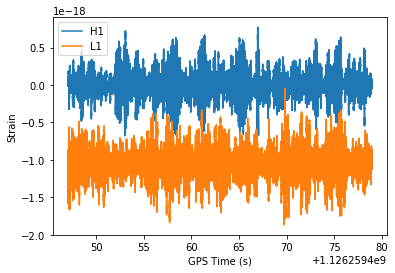

In [17]:
fig = plt.figure()
plt.plot(strain_H1.sample_times, strain_H1, label="H1")
plt.plot(strain_L1.sample_times, strain_L1, label="L1")
plt.ylabel('Strain')
plt.xlabel('GPS Time (s)')
plt.legend()
plt.show();

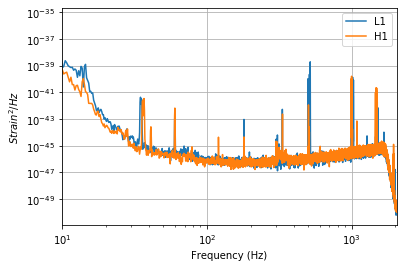

In [18]:
# This estimates the PSD by sub-dividing the data into overlapping
# 4s long segments. (See Welch's method)
psd_L1 = strain_L1.psd(4)
psd_H1 = strain_H1.psd(4)
    
# Note that the psd is a FrequencySeries!
fig = plt.figure()
plt.loglog(psd_L1.sample_frequencies, psd_L1, label="L1")
plt.loglog(psd_H1.sample_frequencies, psd_H1, label="H1")
    
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.xlim(10, 2048)
plt.legend()
plt.show();


In [ ]:
# How is the PSD being calculated?
# It is a welch algorith with a hanning window and median averaging
# Why is the results below are not equal?
NFFT = 1*fs
fmin = 10
fmax = 2000
freqs_L1, Pxx_L1 = signal.welch(strain_L1, fs=fs, nperseg = NFFT, average="median")
freqs_H1, Pxx_H1 = signal.welch(strain_H1, fs=fs, nperseg = NFFT, average="median")
psd_H1 = interp1d(freqs_H1, Pxx_H1, fill_value= "extrapolate")

fig = plt.figure()
plt.loglog(psd_L1.sample_frequencies, psd_L1, label="L1-pycbc")
plt.loglog(freqs_L1, Pxx_L1, label = "L1-welch")
plt.grid("on")
plt.xlim((fmin, fmax))
plt.legend()
plt.show();

In [ ]:
# Whiten the data

# This produces a whitened set.
# This works by estimating the power spectral density from the
# data and then flattening the frequency response.
# (1) The first option sets the duration in seconds of each
#     sample of the data used as part of the PSD estimate.
# (2) The second option sets the duration of the filter to apply
whitened_L1 = strain_L1.whiten(4, 4).time_slice(m.time - 0.5, m.time + 0.5)
whitened_H1 = strain_H1.whiten(4, 4).time_slice(m.time - 0.5, m.time + 0.5)

fig = plt.figure()
plt.plot(whitened_H1.sample_times, whitened_H1, label="H1")
plt.plot(whitened_L1.sample_times, whitened_L1, label="L1")

plt.ylabel('Whitened Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show();


In [ ]:
# Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
bpsd_H1 = whitened_H1.highpass_fir(30, 512).lowpass_fir(250, 512)
bpsd_L1 = whitened_L1.highpass_fir(30, 512).lowpass_fir(250, 512)    
# We'll choose a tighter zoom here.
zoom_H1 = bpsd_H1.time_slice(m.time - 0.2, m.time + .1)
zoom_L1 = bpsd_L1.time_slice(m.time - 0.2, m.time + .1)

fig = plt.figure(figsize=(16,6))
plt.plot(zoom_H1.sample_times, zoom_H1, label="H1")
plt.plot(zoom_L1.sample_times, zoom_L1, label="L1")
plt.grid()
plt.legend()
plt.show();

In [ ]:
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
bpsd_L1.roll(int(bpsd_L1.sample_rate * .007))
bpsd_L1 *= -1

 # We'll choose a tighter zoom here.
zoom_H1 = bpsd_H1.time_slice(m.time - 0.2, m.time + .1)
zoom_L1 = bpsd_L1.time_slice(m.time - 0.2, m.time + .1)

fig = plt.figure(figsize=(16,6))
plt.plot(zoom_H1.sample_times, zoom_H1, label="H1")
plt.plot(zoom_L1.sample_times, zoom_L1, label="L1")
plt.grid()
plt.legend()
plt.show();

In [ ]:
# Let is see the effect of the whitening and filtering in frequency domain
# Note: We did a manual normalization to compare the power spectra 
NFFT = 1*fs
fmin = 10
fmax = 2000
freqs_L1, Pxx_L1 = signal.welch(strain_L1, fs=fs, nperseg = NFFT, average="median")
freqs_L1b, Pxx_L1b = signal.welch(bpsd_L1, fs=fs, nperseg = NFFT/2, average="median")


fig = plt.figure()
plt.loglog(psd_L1.sample_frequencies, psd_L1, label="L1-pycbc")
plt.loglog(freqs_L1, Pxx_L1, label = "L1-welch")
plt.loglog(freqs_L1b, Pxx_L1b*np.median(Pxx_L1), label = "L1-whitened_H1")
plt.grid("on")
plt.xlim((fmin, fmax))
plt.legend()
plt.show();

In [ ]:
# Spectogram
NFFT = int(fs/8)
NOVL = NFFT*15/16
window = np.blackman(NFFT)
spec_cmap = "viridis"
deltat = 5
# We'll choose a tighter zoom here.
zoom_H1 = strain_H1.time_slice(m.time - deltat, m.time + deltat)

# Plot the H1 spectrogram:
plt.figure(figsize = (16,8) )
spec_H1, freqs, bins, im = plt.specgram(zoom_H1, NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(m.time))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near GW150914')
plt.show();

In [ ]:
# Spectogram
NFFT = int(fs/16)
NOVL = NFFT*15/16
window = np.blackman(NFFT)
spec_cmap = "viridis"
deltat = .5
# We'll choose a tighter zoom here.
whitened_H1 = strain_H1.whiten(4, 4)
bpsd_H1 = whitened_H1.highpass_fir(30, 512).lowpass_fir(250, 512)
zoom_H1 = bpsd_H1.time_slice(m.time - deltat, m.time + deltat)

# Plot the H1 spectrogram:
plt.figure(figsize = (16,8) )
spec_H1, freqs, bins, im = plt.specgram(zoom_H1, NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(m.time))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 300])
plt.title('aLIGO H1 strain data near GW150914')
plt.show();

There is a broken function qtransform in pycbc package, due to python3.7 updates and handling of StopIteration exception. The fix was already published in github but may take a little while to reack pip. If the line below breaks, you can manually edit the file qtransform.py, chenge the lines 
````
# raise StopInteraction()
return
````

In [ ]:
                  
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
zoom = whitened_H1
times, freqs, power = zoom.qtransform(delta_t = .001,logfsteps=100,qrange=(8, 8),frange=(20, 512))
plt.figure(figsize=[15, 3])
plt.pcolormesh(times, freqs, power**0.5)
plt.xlim(m.time - 0.5, m.time + 0.3)
plt.title("H1")
plt.yscale('log')
plt.show();

In [ ]:
# B ayes
try:
    import pymc3
except ImportError:
    import sys
    !{sys.executable} -m pip install pymc3 arviz corner

In [1]:
import pymc3 as pm
import corner
import matplotlib.pyplot as plt

In [14]:
# ----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)


np.random.seed(0)

N = 1000
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
sigma = 2.0

true_params = np.array([b0_true, A_true, np.log(beta_true), np.log(omega_true)])

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

In [17]:
# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50, testval=50 * np.random.random())
    A = pm.Uniform('A', 0, 50, testval=50 * np.random.random())
    log_beta = pm.Uniform('log_beta', -5, -4, testval=-4.6)
    log_omega = pm.Uniform('log_omega', -5, -1, testval=-2.3)

    y = pm.Normal('y', mu=chirp(t, b0, np.exp(log_beta), A, np.exp(log_omega)),
                  sd=sigma, observed=y_obs)

    # Choose the Metropolis-Hastings step rather than rely on the default
    step = pm.Metropolis()
    traces = pm.sample(draws=50000, tune=2000, step=step, cores = 4)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [log_omega]
>Metropolis: [log_beta]
>Metropolis: [A]
>Metropolis: [b0]
Sampling 4 chains: 100%|██████████| 208000/208000 [01:25<00:00, 2433.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [18]:
# ----------------------------------------------------------------------
# Use the summary() function to provide statistics for each variable
mean_vals = pm.summary(traces)['mean']
mean_vals['omega'] = np.exp(mean_vals.pop('log_omega'))
mean_vals['beta'] = np.exp(mean_vals.pop('log_beta'))

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

/opt/conda/envs/cosmos3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


In [19]:
pm.summary(traces)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0,10.057578,0.063343,0.000353,9.936088,10.183527,31712.056930,1.000180
A,5.004505,0.089709,0.000509,4.826023,5.179402,30805.329651,1.000118
log_beta,-4.604646,0.001639,0.000048,-4.607772,-4.601334,1157.280397,1.000044
log_omega,-2.306149,0.012812,0.000373,-2.330696,-2.280361,1167.143941,1.000052


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1162c077f0>,
      dtype=object)

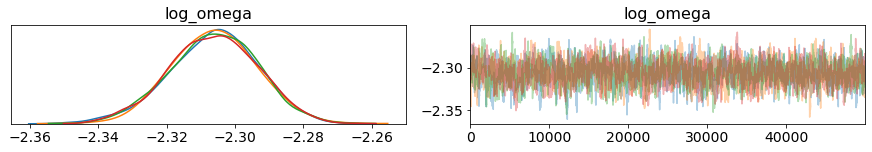

In [20]:
pm.plots.traceplot(traces, var_names="log_omega")

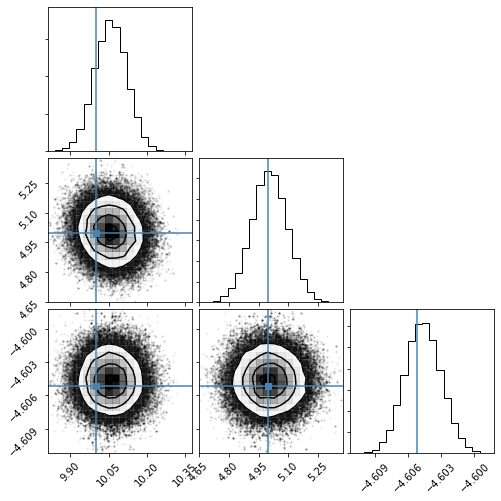

In [21]:
samples = np.vstack([traces[k] for k in ["b0", "A", "log_beta"]]).T
corner.corner(samples, truths=true_params);

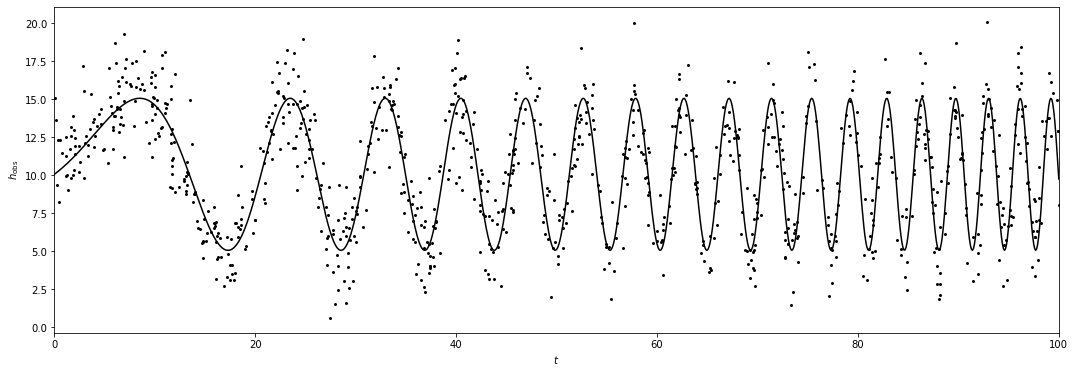

In [22]:
fig = plt.figure(figsize=(18, 6))

t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, **mean_vals)


# ----------------------------------------------------------------------
# Plot multiple panels with the traces
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')


plt.show();